In [234]:
import urllib.request
from urllib.request import Request, urlopen
from bs4 import BeautifulSoup
import csv
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from ipywidgets import widgets, interactive

# Fire Emblem: Heroes Character Analysis

## Introduction

In this project, we will be taking a look at character data from the popular mobile game *Fire Emblem: Heroes* available on iPhone and Android. Fire Emblem, a strategy RPG franchise developed by Intelligent System, added this mobile game to its list of entries following the popularity of recent titles *Fire Emblem: Awakening* and *Fire Emblem: Fates* for the 3DS. In this entry, you are in the position of a tactician, deploying up to four characters from the Fire Emblem Universe to do battle against the opposing enemy team. The game utilizes a rock-paper-scissors battle mechanic, with some weapons being superior to others. 

Like many popular mobile games, *Fire Emblem: Heroes* is a free-to-play Gacha game, where characters are drawn from a random pool, each with varying rarity and power. 

## Web-Scraping

We begin this project by obtaining the character data, using data hosted on gamepedia.com (I do not own the data).

In [58]:
class AppURLopener(urllib.request.FancyURLopener):
    version = "Mozilla/5.0"

opener = Request("https://feheroes.gamepedia.com/Stats_Table",
                headers = {"User-Agent": "Mozilla/5.0"})

# query the website and return the html to the variable 'webpage'

webpage = urlopen(opener).read()

# parse the html using beautiful soup and store in variable 'soup'
soup = BeautifulSoup(webpage, 'html.parser')

In [59]:
# Take out the <div> of name and get its value
right_table=soup.find('table', id = "max-stats-table")
length = len(right_table.findAll("tr"))

# variable placeholders for respective column info for data frame
name = []
color = []
weapon_type = []
mov_type = []
hp = []
atk = []
spd = []
defense = []
res = []
total = []

#inserting values into the placeholders
i = 0
for row in right_table.findAll("tr"):
    if i == 0:
        i += 1
        continue
    val = []
    val = row["data-weapon-type"].split()
    color.append(val[0])
    weapon_type.append(val[1])
    mov_type.append(row["data-move-type"])
    cells = row.findAll('td')
    name.append(cells[0].findAll('a')[0]["title"])
    hp.append(int(cells[4].find(text=True)))
    atk.append(int(cells[5].find(text=True)))
    spd.append(int(cells[6].find(text=True)))
    defense.append(int(cells[7].find(text=True)))
    res.append(int(cells[8].find(text=True)))
    total.append(int(cells[9].find(text=True)))

In [60]:
# creating the data frame using pandas
df = pd.DataFrame(name,columns=['Name'])
df["Color"] = color
df['Weapon Type'] = weapon_type
df['Movement Type'] = mov_type
df['HP'] = hp
df['Attack'] = atk
df['Speed'] = spd
df['Defense'] = defense
df['Resistance'] = res
df['Total'] = total

This gives us a dataframe that details the battle-related statistics of each character, including their weapon type, movement type, and the values for each of their stats.

We will take a look at the dataframe for all the renditions of the character named Ike from *Fire Emblem: Path of Radiance* and *Fire Emblem: Radiant Dawn*.

In [133]:
df[df['Name'].str.contains("Ike")]

,Name,Color,Weapon Type,Movement Type,HP,Attack,Speed,Defense,Resistance,Total
144,Ike: Brave Mercenary,Green,Axe,Infantry,43,36,28,35,20,162
145,Ike: Stalwart Heart,Red,Sword,Armored,45,37,38,35,19,174
146,Ike: Vanguard Legend,Red,Sword,Infantry,41,36,30,35,21,163
147,Ike: Young Mercenary,Red,Sword,Infantry,42,35,31,32,18,158


However, there's more data that is involved with each character. We also would like to obtain information regarding what Fire Emblem game they are from originally, when the character was first introduced into FE Heroes, what rarities they are available at, how they can be obtained in the game, and whether they are one of the distinct "Legendary Heroes" or not (we will be doing an analysis on them later). We will be using another link from gamepedia.com to do so:

In [187]:
#grab universe from link
    
opener2 = Request("https://feheroes.gamepedia.com/Hero_list",
        headers = {"User-Agent": "Mozilla/5.0"})

# query the website and return the html to the variable 'webpage'

universe = urlopen(opener2).read()

# parse the html using beautiful soup and store in variable 'soup'
uni = BeautifulSoup(universe, 'html.parser')

left_table=uni.find('table')
length = len(left_table.findAll("tr"))

# variable placeholders for respective column info for data frame
nombre = []
origin = []
col = []
weap_type = []
move_type = []
rarities = []
st_tt = []
release = []
lgd = []

tab_vals = left_table.findAll("tr")

for ind in range(1, len(tab_vals)):
    val = []
    val = tab_vals[ind]["data-weapon-type"].split()
    cells = tab_vals[ind].findAll("td")
    
    nombre.append(cells[1].findAll('a')[0]["title"])
    origin.append(cells[2].find(text=True))
    rare = (cells[5].findAll(text=True))
    add = []
    legend = False
    for i in np.arange(len(rare)):
        app = "None"
        if str(rare[i]).find("–") != -1:
            rare[i] = str(rare[i]).replace("–", "")
        if rare[i].find(" ") != -1:
            rare[i] = str(rare[i]).replace(" ", "")
        if rare[i] == "TempestTrials":
            app = "Tempest Trials"
        if rare[i] == "GrandHeroBattle":
            app = "Grand Hero Battle"
        if rare[i] == "Story":
            app = "Story"
        if i + 1 == len(rare):
            st_tt.append(app)
        if rare[i] in ("3", "4", "5"):
            add.append(int(rare[i]))
        if rare[i] == "Legendary":
            legend = True
    lgd.append(legend)
    rarities.append(add)
    release.append(cells[6].find(text=True))
    
    
# creating the data frame using pandas
df2 = pd.DataFrame(nombre,columns=['Name'])
df2["Origin"] = origin
df2['Rarities'] = rarities
df2['Story/TT/GHB?'] = st_tt
df2['Release Date'] = release
df2["Legendary"] = lgd

Now we have our second dataframe which, when running the cell below, looks like this:

In [251]:
with pd.option_context('display.max_rows', 5, 'display.max_columns', 100):
    display(df2)

,Name,Origin,Rarities,Story/TT/GHB?,Release Date,Legendary
0,Abel: The Panther,Fire Emblem: Mystery of the Emblem,"[3, 4]",None,2017-02-02,False
1,Alfonse: Prince of Askr,Fire Emblem Heroes,[4],Story,2017-02-02,False
...,...,...,...,...,...,...
385,Zelgius: Jet-Black General,Fire Emblem: Radiant Dawn,[5],None,2018-01-12,False
386,Zephiel: The Liberator,Fire Emblem: The Binding Blade,"[3, 4]",Grand Hero Battle,2017-04-20,False


And then we merge the two dataframes together to create a dataframe called "heroes", which contains all of the available data on each character. The following cell will both merge the two dataframes together, as well as give us the first five rows of our new dataframe.

In [242]:
heroes = pd.merge(df2, df, on = "Name")
heroes.head()
#with pd.option_context('display.max_rows', None, 'display.max_columns', 100):
#    display(heroes)

,Name,Origin,Rarities,Story/TT/GHB?,Release Date,Legendary,Color,Weapon Type,Movement Type,HP,Attack,Speed,Defense,Resistance,Total
0,Abel: The Panther,Fire Emblem: Mystery of the Emblem,"[3, 4]",None,2017-02-02,False,Blue,Lance,Cavalry,39,33,32,25,25,154
1,Alfonse: Prince of Askr,Fire Emblem Heroes,[4],Story,2017-02-02,False,Red,Sword,Infantry,43,35,25,32,22,157
2,Alfonse: Spring Prince,Fire Emblem Heroes,[5],None,2018-03-22,False,Green,Axe,Cavalry,41,35,33,30,18,157
3,Alm: Hero of Prophecy,Fire Emblem Echoes: Shadows of Valentia,[5],None,2017-04-14,False,Red,Sword,Infantry,45,33,30,28,22,158
4,Alm: Saint-King,Fire Emblem Echoes: Shadows of Valentia,[5],None,2019-04-27,True,Colorless,Bow,Infantry,40,37,37,26,22,162


## Data Visualization

In this section, we'll take a deeper look at the data that we just scraped to give ourselves a better idea of what we're working with. Some of the features that we'll be looking at are related to character statistics, weapon type, color, and game origin.

### Stat Distribution

In [ ]:
# Make drop down for comparison of unit composition

cat_comp = widgets.Dropdown(
    options=["Weapon Type", "Movement Type", "Color"],
    value="Weapon Type",
    description="Category:",
)

stat_comp = widgets.Dropdown(
    options=["HP", "Attack", "Speed", "Defense", "Resistance"],
    value='HP',
    description='Stat:',
)

def plotit(cat, stat):
    plt.figure(figsize=(8, 5))
    sns.set(style="ticks")
    if cat == "Color":
        sns.violinplot(x= cat, y= stat, data=heroes, palette=["#3498db", "#fe2c54", "#12e193", "#bf77f6"])
    elif cat == "Weapon Type":
        sns.violinplot(x= cat, y= stat, data=heroes, palette="Set3")
    else:
        sns.violinplot(x= cat, y= stat, data=heroes, palette="hls")

interactive(plotit, cat = cat_comp, stat = stat_comp)

7

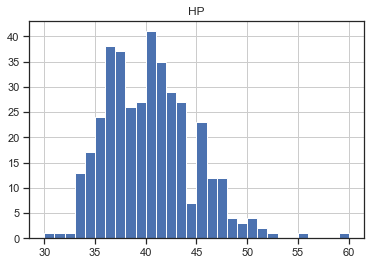

In [67]:
# create a button to allow someone to choose a character and where a certain stat falls in a distribution of that stat
# possibly subset that distribution

heroes.hist("HP", bins = max(heroes["HP"]) - min(heroes["HP"]))
len(heroes[heroes["HP"] == 44])

### Character Distribution

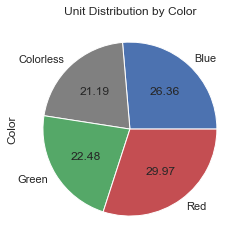

In [189]:
# See the number of characters for each color

colors = heroes.groupby(by="Color").agg(np.size).iloc[:, 6]
colors = colors.rename("Color")
colors.plot.pie(labels=['Blue', 'Colorless', 'Green', 'Red'], colors=['b', 'gray', 'g', 'r'], autopct='%.2f')
plt.title("Unit Distribution by Color")
plt.show()

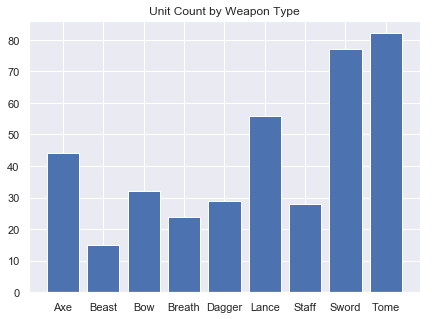

In [69]:
# See the number of characters for each weapon type
plt.figure(figsize=(7, 5))
plt.bar([0, 1, 2, 3, 4, 5, 6, 7, 8], heroes.groupby(by = "Weapon Type").agg(np.size).iloc[:, 0], align = "center")
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8], heroes.groupby(by = "Weapon Type").agg(np.size).index)
plt.title("Unit Count by Weapon Type")
plt.show()

We see that characters that use tomes are the most abundant in the game (barely beating out those who use swords). However, we should note that there are three different colors associated with tome users, while sword users are all red. Below we will show a distribution of the color of tome users.

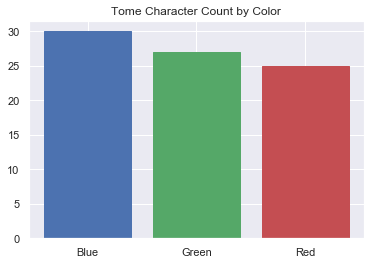

In [70]:
# Tome
tomebar = plt.bar([0, 1, 2], heroes.loc[heroes["Weapon Type"] == "Tome"].groupby(by = "Color").agg(np.size).iloc[:, 0], align = "center")
tomebar[np.where(heroes.loc[heroes["Weapon Type"] == "Tome"].groupby(by = "Color").agg(np.size).index.values == "Red")[0][0]].set_color('r')
tomebar[np.where(heroes.loc[heroes["Weapon Type"] == "Tome"].groupby(by = "Color").agg(np.size).index.values == "Blue")[0][0]].set_color('b')
tomebar[np.where(heroes.loc[heroes["Weapon Type"] == "Tome"].groupby(by = "Color").agg(np.size).index.values == "Green")[0][0]].set_color('g')
plt.xticks([0, 1, 2], heroes.loc[heroes["Weapon Type"] == "Tome"].groupby(by = "Color").agg(np.size).index)
plt.title("Tome Character Count by Color")
plt.show()

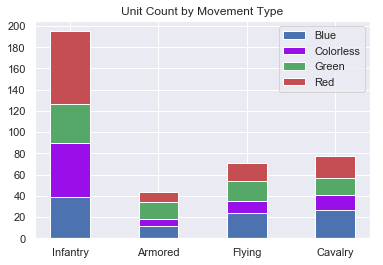

In [71]:
# See the number of characters for each movement type

mov_ty = ["Infantry", "Armored", "Flying", "Cavalry"]
inf = (heroes[heroes["Movement Type"] == mov_ty[0]].groupby(by = "Color").agg(np.size).iloc[:, 0])
arm = (heroes[heroes["Movement Type"] == mov_ty[1]].groupby(by = "Color").agg(np.size).iloc[:, 0])
fly = (heroes[heroes["Movement Type"] == mov_ty[2]].groupby(by = "Color").agg(np.size).iloc[:, 0])
cav = (heroes[heroes["Movement Type"] == mov_ty[3]].groupby(by = "Color").agg(np.size).iloc[:, 0])
inds = heroes[heroes["Movement Type"] == mov_ty[0]].groupby(by = "Color").agg(np.size).index
inds

zos = np.array((inf[0], arm[0], fly[0], cav[0]))
ones = np.array((inf[1], arm[1], fly[1], cav[1]))
twos = np.array((inf[2], arm[2], fly[2], cav[2]))
tres = np.array((inf[3], arm[3], fly[3], cav[3]))

ind = np.arange(4)    
width = 0.45      

p1 = plt.bar(ind, zos, width, color = "b")
p2 = plt.bar(ind, ones, width,  bottom=zos, color = "xkcd:violet")
p3 = plt.bar(ind, twos, width,  bottom= zos + ones, color = "g")
p4 = plt.bar(ind, tres, width, bottom = zos + ones + twos, color = "r")

plt.title("Unit Count by Movement Type")
plt.xticks(ind, ("Infantry", "Armored", "Flying", "Cavalry"))
plt.yticks(np.arange(0, np.sum(inf) + 10, 20))
plt.legend((p1[0], p2[0], p3[0], p4[0]), (inds))

plt.show()

#heroes.groupby(by = "Movement Type").agg(np.size).iloc[:, 0].groupby(by = "Color").agg(np.size).iloc[:, 0]

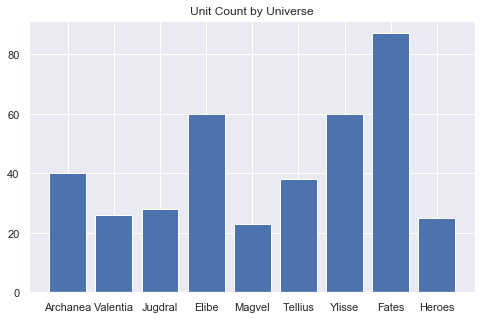

In [72]:
# See the number of characters for each universe
Universes = []

Archanea = len(heroes.loc[heroes["Origin"] == "Fire Emblem: Mystery of the Emblem"]) \
+ len(heroes.loc[heroes["Origin"] == "Fire Emblem: Shadow Dragon and the Blade of Light"]) \
+ len(heroes.loc[heroes["Origin"] == "Fire Emblem: New Mystery of the Emblem"])
Valentia = len(heroes.loc[heroes["Origin"] == "Fire Emblem Echoes: Shadows of Valentia"])
Jugdral = len(heroes.loc[heroes["Origin"] == "Fire Emblem: Genealogy of the Holy War"]) \
+ len(heroes.loc[heroes["Origin"] == "Fire Emblem: Thracia 776"])
Elibe = len(heroes.loc[heroes["Origin"] == "Fire Emblem: The Blazing Blade"]) \
+ len(heroes.loc[heroes["Origin"] == "Fire Emblem: The Binding Blade"])
Magvel = len(heroes.loc[heroes["Origin"] == "Fire Emblem: The Sacred Stones"])
Tellius = len(heroes.loc[heroes["Origin"] == "Fire Emblem: Path of Radiance"]) \
+ len(heroes.loc[heroes["Origin"] == "Fire Emblem: Radiant Dawn"])
Ylisse = len(heroes.loc[heroes["Origin"] == "Fire Emblem Awakening"])
Fates = len(heroes.loc[heroes["Origin"] == "Fire Emblem Fates"])
Heroes = len(heroes.loc[heroes["Origin"] == "Fire Emblem Heroes"])
     
Universes.append(Archanea)
Universes.append(Valentia)
Universes.append(Jugdral)
Universes.append(Elibe)      
Universes.append(Magvel)
Universes.append(Tellius)
Universes.append(Ylisse)
Universes.append(Fates)
Universes.append(Heroes)

plt.figure(figsize=(8, 5))
plt.bar(np.arange(9), Universes, align = "center")
plt.xticks(np.arange(9), ["Archanea", "Valentia", "Jugdral", "Elibe", "Magvel", "Tellius", "Ylisse", "Fates", "Heroes"])
plt.title("Unit Count by Universe")
plt.show()

## Legendary Hero Analysis - Are they actually "Legendary"?

One new feature that was introduced into the game in the last year was the addition of "Legendary Heroes". These heroes, aside from a few originally from FE Heroes, are renditions of some of the most popular/powerful characters in the franchise with some changes compared to the original character. Some units change movement type, weapon type, or even both, while also gaining unique skills and personalized weapons. From the title of being a "Legendary Hero", one would think that these characters are the best of the best. However, is this the case based solely on their stats? 

First, we'll start off by looking at the list of legendary characters:

In [193]:
legend = heroes[heroes["Legendary"] == True]
legend

,Name,Origin,Rarities,Story/TT/GHB?,Release Date,Legendary,Color,Weapon Type,Movement Type,HP,Attack,Speed,Defense,Resistance,Total
4,Alm: Saint-King,Fire Emblem Echoes: Shadows of Valentia,[5],None,2019-04-27,True,Colorless,Bow,Infantry,40,37,37,26,22,162
18,Azura: Vallite Songstress,Fire Emblem Fates,[5],None,2018-12-28,True,Blue,Tome,Flying,33,30,35,17,24,139
81,Eirika: Graceful Resolve,Fire Emblem: The Sacred Stones,[5],None,2018-10-31,True,Red,Sword,Cavalry,38,31,39,27,21,156
91,Ephraim: Legendary Lord,Fire Emblem: The Sacred Stones,[5],None,2018-02-28,True,Blue,Lance,Cavalry,43,36,27,33,18,157
106,Fjorm: Princess of Ice,Fire Emblem Heroes,[5],None,2017-11-28,True,Blue,Lance,Infantry,39,30,31,30,34,164
122,Gunnthrá: Voice of Dreams,Fire Emblem Heroes,[5],None,2017-12-28,True,Green,Tome,Cavalry,37,31,33,19,25,145
133,Hector: Marquess of Ostia,Fire Emblem: The Blazing Blade,[5],None,2018-06-28,True,Green,Axe,Armored,47,40,23,38,26,174
141,Hríd: Icy Blade,Fire Emblem Heroes,[5],None,2018-11-28,True,Red,Sword,Cavalry,41,37,17,36,26,157
146,Ike: Vanguard Legend,Fire Emblem: Radiant Dawn,[5],None,2018-01-31,True,Red,Sword,Infantry,41,36,30,35,21,163
208,Lucina: Glorious Archer,Fire Emblem Awakening,[5],None,2018-07-31,True,Blue,Bow,Infantry,36,34,35,25,20,150


### Compared to Other Versions of the Same Character:

When looking at some of the legendary heroes compared to alternate versions of themselves, some seem to have significantly higher stats:

In [181]:
heroes[heroes['Name'].str.contains("Tiki")][["Name", "Release Date", "Legendary", "Color", "Weapon Type", 
                   "Movement Type", "HP", "Attack", "Speed", "Defense", "Resistance", "Total"]]

,Name,Release Date,Legendary,Color,Weapon Type,Movement Type,HP,Attack,Speed,Defense,Resistance,Total
361,Tiki: Beachside Scion,2018-07-10,False,Red,Breath,Flying,40,33,37,32,26,168
362,Tiki: Dragon Scion,2017-02-02,False,Red,Breath,Infantry,41,31,30,32,29,163
363,Tiki: Legendary Dragon,2018-09-28,True,Blue,Breath,Armored,45,34,35,37,29,180
364,Tiki: Naga's Voice,2017-02-02,False,Red,Breath,Infantry,40,35,23,35,24,157
365,Tiki: Summering Scion,2017-06-30,False,Green,Axe,Infantry,35,36,30,32,24,157
366,Tiki: Torpid Dragon,2019-05-10,False,Colorless,Breath,Armored,45,36,34,37,28,180


Some seem to have noticeably lower stats:

In [182]:
heroes[heroes['Name'].str.contains("Azura")][["Name", "Release Date", "Legendary", "Color", "Weapon Type", 
                   "Movement Type", "HP", "Attack", "Speed", "Defense", "Resistance", "Total"]]

,Name,Release Date,Legendary,Color,Weapon Type,Movement Type,HP,Attack,Speed,Defense,Resistance,Total
15,Azura: Celebratory Spirit,2017-12-31,False,Green,Axe,Flying,37,30,35,22,26,150
16,Azura: Lady of Ballads,2017-09-29,False,Green,Axe,Infantry,35,32,34,20,28,149
17,Azura: Lady of the Lake,2017-02-02,False,Blue,Lance,Infantry,36,31,33,21,28,149
18,Azura: Vallite Songstress,2018-12-28,True,Blue,Tome,Flying,33,30,35,17,24,139
19,Azura: Young Songstress,2018-11-12,False,Green,Tome,Infantry,36,33,29,17,25,140


And some of them seem to have near identical statlines as other versions:

In [183]:
heroes[heroes['Name'].str.contains("Hector")][["Name", "Release Date", "Legendary", "Color", "Weapon Type", 
                   "Movement Type", "HP", "Attack", "Speed", "Defense", "Resistance", "Total"]]

,Name,Release Date,Legendary,Color,Weapon Type,Movement Type,HP,Attack,Speed,Defense,Resistance,Total
130,Hector: Brave Warrior,2018-08-21,False,Blue,Lance,Armored,48,37,22,39,28,174
131,Hector: General of Ostia,2017-02-02,False,Green,Axe,Armored,52,36,24,37,19,168
132,Hector: Just Here to Fight,2018-02-09,False,Green,Axe,Armored,50,38,21,40,24,173
133,Hector: Marquess of Ostia,2018-06-28,True,Green,Axe,Armored,47,40,23,38,26,174


Thus, it is not very useful to compare legendary units with other versions of said character. One thing to note is that legendary heroes often showcase a customized design and build compared to their original counterparts. For a number of the legendary heroes, they use a different weapon type and may not even be of the same movement type. Hence, may be more useful to compare them with other units of like weapon and like movement type.

We will look to compare the stats of these characters with those of similar weapon and move type to see where they fall in the distribution of characters.

In [232]:
# Make drop down for comparison of unit composition

legend_comp = widgets.Dropdown(
    options = legend["Name"].unique(),
    value = legend["Name"].unique()[0],
    description = "Name:",
)

stat_comp = widgets.Dropdown(
    options=["HP", "Attack", "Speed", "Defense", "Resistance"],
    value='HP',
    description='Stat:',
)

def plotsit(leg, stat):
    plt.figure(figsize=(8, 5))
    leghero = legend[legend["Name"] == leg]
    display(leghero[["Name", "Origin", "Release Date", "Color", "Weapon Type", "Movement Type",
                   "HP", "Attack", "Speed", "Defense", "Resistance", "Total"]])
    tab = heroes[heroes["Weapon Type"] == leghero["Weapon Type"].iloc[0]]
    tab2 = tab[tab["Movement Type"] == leghero["Movement Type"].iloc[0]]
    plt.axvline(leghero[stat].item(), color='r', linestyle='dashed', linewidth=1)
    #plt.hist(tab2[stat], bins = max(tab2[stat]) - min(tab2[stat]) + 1)
    #plt.xticks(np.arange(min(tab2[stat]), max(tab2[stat]) + 1))
    tab2[stat].hist(bins = np.arange(min(tab2[stat]), max(tab2[stat]) + 1, 1), 
                    range = np.arange(min(tab2[stat]), max(tab2[stat]) + 1, 1), align = "left")
    mi = min(tab2[stat])
    ma = max(tab2[stat])
    #plt.xticks(np.arange(mi, ma + 1, 1))
    plt.show()

interactive(plotsit, leg = legend_comp, stat = stat_comp)

interactive(children=(Dropdown(description='Name:', options=('Alm: Saint-King', 'Azura: Vallite Songstress', '…

We will also create a dataframe to detail the percentile of each hero's stats in their respective distribution.

In [250]:
legend_perc = pd.DataFrame(columns = ["Name", "HP", "Attack", "Speed", "Defense", "Resistance", "Total"])

for char in legend["Name"].unique():
    legend_perc = legend_perc.append({'Name': char, 'HP': 0, 'Attack': 0, 'Speed': 0, 'Defense': 0, 'Resistance': 0,
                                     'Total': 0}, ignore_index=True)
    for stat in ["HP", "Attack", "Speed", "Defense", "Resistance", "Total"]:
        perc = stats.percentileofscore(heroes[stat], legend[legend["Name"].str.contains(char)][stat].item(), 
                                       kind = "weak")
        legend_perc.loc[legend_perc["Name"] == char, stat] = perc

legend_perc

,Name,HP,Attack,Speed,Defense,Resistance,Total
0,Alm: Saint-King,58.3979,94.3152,93.5401,48.5788,34.6253,79.3282
1,Azura: Vallite Songstress,4.13437,22.739,78.2946,13.4367,45.9948,1.03359
2,Eirika: Graceful Resolve,40.8269,32.0413,99.2248,53.4884,27.3902,51.6796
3,Ephraim: Legendary Lord,81.9121,89.4057,25.5814,81.3953,12.1447,66.4083
4,Fjorm: Princess of Ice,47.8036,22.739,40.0517,67.4419,95.6072,85.7881
5,Gunnthrá: Voice of Dreams,34.1085,32.0413,54.2636,19.8966,52.7132,9.56072
6,Hector: Marquess of Ostia,95.8656,98.9664,11.6279,97.6744,59.4315,97.416
7,Hríd: Icy Blade,67.4419,94.3152,1.55039,93.2817,59.4315,66.4083
8,Ike: Vanguard Legend,67.4419,89.4057,35.9173,89.9225,27.3902,84.4961
9,Lucina: Glorious Archer,24.5478,67.9587,78.2946,45.2196,22.2222,35.4005


If you look carefully at the above dataframe, you can see that there is an immenese range in the statistical prowess for legendary characters. One of the characters is tied for the highest stat total (Tiki), meanwhile another is barely above the 1st percentile (Azura). However, many would agree that Azura is one of the more useful characters available, despite her low stat total (the GamePress Offensive Tier List has her at the highest tier).

However, only four of the sixteen currently-available legendary heroes are below average in terms of total stats, so there appears to be some correlation.

One other interesting note is that only six of the 16 are below the 78th percentile for speed, possibly an indicator of the importance of that particular in the game (which, in my experience, is the case). At least some of those six have unique skills that account for their lack of speed.

From what we see above, what makes a legendary hero "legendary" cannot be seen merely by their stat distribution. Personalized weapons, skills tied to particular legendary heroes, and in-game roles are just some of the factors that are likely to help distinguish these heroes from the rest of the field (aside from grandiose designs). More analysis will be made into that another time.

## Coming Soon: Is the Power-Creep Real?

One of the most annoying things about gacha games is that you spend time grooming and building a character that you really like and is good at the time, only for it to be trumped a few months later by a new character of similar build but better in more ways than one. With the ever-growing list of characters in FE Heroes, it's more than likely that old favorites have been subjected to the "power creep", and the ones that are the most popular today will be left in the dust in a few iterations of characters.

In [151]:
heroes[heroes["Release Date"] == "2017-02-02"]

,Name,Origin,Rarities,Story/TT/GHB?,Release Date,Legendary,Color,Weapon Type,Movement Type,HP,Attack,Speed,Defense,Resistance,Total
0,Abel: The Panther,Fire Emblem: Mystery of the Emblem,"[3, 4]",None,2017-02-02,False,Blue,Lance,Cavalry,39,33,32,25,25,154
1,Alfonse: Prince of Askr,Fire Emblem Heroes,[4],Story,2017-02-02,False,Red,Sword,Infantry,43,35,25,32,22,157
6,Anna: Commander,Fire Emblem Heroes,[4],Story,2017-02-02,False,Green,Axe,Infantry,41,29,38,22,28,158
9,Arthur: Hapless Hero,Fire Emblem Fates,"[3, 4]",None,2017-02-02,False,Green,Axe,Infantry,43,32,29,30,24,158
14,Azama: Carefree Monk,Fire Emblem Fates,"[3, 4]",None,2017-02-02,False,Colorless,Staff,Infantry,43,21,26,32,25,147
17,Azura: Lady of the Lake,Fire Emblem Fates,[5],None,2017-02-02,False,Blue,Lance,Infantry,36,31,33,21,28,149
20,Barst: The Hatchet,Fire Emblem: Mystery of the Emblem,"[3, 4]",None,2017-02-02,False,Green,Axe,Infantry,46,33,32,30,17,158
21,Bartre: Fearless Warrior,Fire Emblem: The Binding Blade,"[3, 4]",None,2017-02-02,False,Green,Axe,Infantry,49,36,25,33,13,156
24,Beruka: Quiet Assassin,Fire Emblem Fates,"[3, 4]",None,2017-02-02,False,Green,Axe,Flying,46,29,23,37,22,157
30,Caeda: Talys's Heart,Fire Emblem: Mystery of the Emblem,"[3, 4]",None,2017-02-02,False,Red,Sword,Flying,36,25,37,24,34,156
